In [4]:
import time
from typing import Optional
import chipwhisperer as cw
from Crypto.Cipher import AES
from tqdm.notebook import tnrange

In [5]:
def configure_target(fpga_id='100t'):
    target = cw.target(None, cw.targets.CW305, force=True, fpga_id=fpga_id)
    
    target.vccint_set(1.0)
    target.pll.pll_enable_set(True)
    target.pll.pll_outenable_set(False, 0)
    target.pll.pll_outenable_set(True, 1)
    target.pll.pll_outenable_set(False, 2)
    target.pll.pll_outfreq_set(10E6, 1)

    target.clkusbautooff = True
    target.clksleeptime = 1

    return target

target = configure_target()

OSError: Unable to communicate with found ChipWhisperer. Check that 
another process isn't connected to it and that you have permission to communicate with it.

In [ ]:
import pyvisa as visa
import numpy as np
resources = visa.ResourceManager() # Create a resource manager object to handle VISA resources
usbDevices = list(filter(lambda x: 'USB' in x, resources.list_resources()))
if len(usbDevices) == 0:
    print("no usb devices found")
    sys.exit(-1)
print(usbDevices[0])
scope = resources.open_resource(usbDevices[0]) # Open a connection to the first USB device
print(scope.query('*IDN?')) #Return the Rigol’s ID string to tell us it’s there
scope.write(":CHAN1:PROB 1") # Set the probe attenuation for channel 1 to 1x
scope.write(":CHAN1:SCAL 0.01") # Set the vertical scale for channel 1 to 10mV/div
scope.write(":CHAN1:COUP AC") # Set the coupling mode for channel 1 to AC
scope.write(":TIM:MAIN:SCAL 0.00001") # Set the timebase scale to 10 microseconds/div
scope.write(':ACQ:SRAT 100e6') # Set the acquisition sample rate to 100 MSa/s
scope.write(":WAV:SOUR CHAN1") # Set the waveform source to channel 1
scope.write(":WAV:MODE RAW")   # Set the waveform mode to raw data
scope.write(":CHAN1:BWLimit 20M") # Enable the 20 MHz bandwidth limit for channel 1 (This added as a correctness method)
scope.write("TRIGGER:EDGE:LEVEL 0.1") # Set the trigger level to 0.1V
scope.write("ACQUIRE:TYPE NORMAL") # Set the acquisition type to normal
scope.write("ACQUIRE:COUNT 1") # Set the number of averages to 1 for acquisition

# Initialize the key and plaintext generator
ktp = cw.ktp.Basic()

# Lists to store keys and plaintexts
textin = []
keys = []
N = 1000  # Number of traces
traces = []

# Initialize cipher to verify DUT result
key, text = ktp.next()
cipher = AES.new(bytes(key), AES.MODE_ECB)

# Create a new ChipWhisperer project
project_file = "projects/Tutorial_HW_CW305.cwp"
project = cw.create_project(project_file, overwrite=True)

# Capture traces
for i in tnrange(N, desc='Capturing traces'):
    # Generate next key and plaintext pair
    key, text = ktp.next()
    textin.append(text)
    keys.append(key)
    
    # Encrypt using the CW305 target
    ciphertext = cw.encrypt(target, text, key)
    # Verify the encryption result against the expected value
    expected_ciphertext = cipher.encrypt(bytes(text))
    assert list(ciphertext) == list(expected_ciphertext), \
        f"Incorrect encryption result! Got {ciphertext} Exp {list(expected_ciphertext)}"
        
    scope.write("TRIGGER:STATE RUN")# Arm the trigger for the oscilloscope   
    scope.write("*TRG")  # Manually trigger the oscilloscope    
    scope.query("*OPC?") # Wait for the operation to complete      
    scope.write("WAV:DATA?") #Request the waveform data from the oscilloscope    
    trace_data = scope.read_raw() # Read the raw waveform data   
    trace = np.frombuffer(trace_data, dtype=np.uint8) #Convert the raw data to a numpy array   
    traces.append(trace) # Append the trace data to the list of traces
    project.traces.append(cw.Trace(trace, text, ciphertext ,key))  #Append the trace, plaintext, ciphertext, and key to the project 
 
project.save()

# Reset the oscilloscope
scope.write("*rst; *cls")

print(f"Captured {len(traces)} traces for {N} encrypted plaintexts.")

USB0::0x2A8D::0x1770::MY58491988::INSTR
KEYSIGHT TECHNOLOGIES,MSO-X 3104T,MY58491988,07.30.2019051434



Capturing traces:   0%|          | 0/1000 [00:00<?, ?it/s]

Captured 1000 traces for 1000 encrypted plaintexts.


Traces shape: (5, 10011)


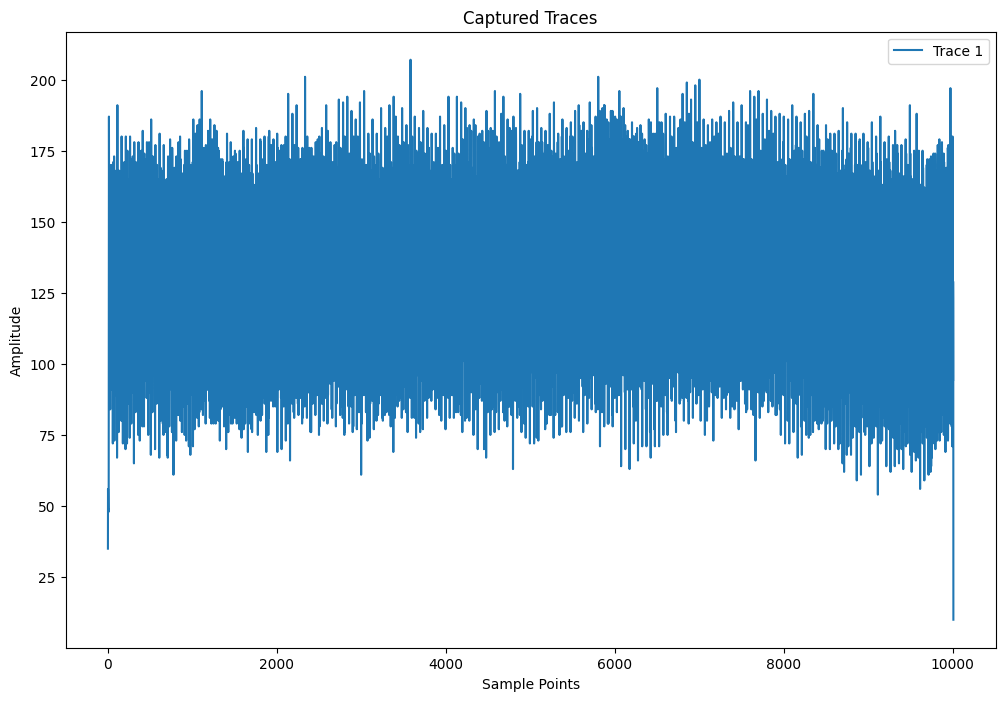

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Load the traces from the .npy file
traces = np.load('traces1.npy')

# Check the shape of the traces array
print(f"Traces shape: {traces.shape}")

# Plot a few traces
num_traces_to_plot = 1  # Number of traces to plot
plt.figure(figsize=(12, 8))

for i in range(num_traces_to_plot):
    plt.plot(traces[i], label=f'Trace {i+1}')

plt.title('Captured Traces')
plt.xlabel('Sample Points')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [22]:
# Load the traces from the .npy file
traces = np.load('traces1.npy')

# Determine the number of traces and the length of each trace
num_traces, trace_length = traces.shape
print(f"Number of traces collected: {num_traces}")
print(f"Length of each trace: {trace_length}")

# Display numerical values of a specific trace
trace_index = 1  # Index of the trace to display
num_values_to_display =20   # Number of values to display from the trace

print(f"Numerical values of trace {trace_index + 1}:")
print(traces[trace_index][:num_values_to_display])

Number of traces collected: 5
Length of each trace: 10011
Numerical values of trace 2:
[ 35  56  48  48  48  49  48  48  48  48 112 134 162 158 142 137  56  98
 123 144]


In [ ]:
import chipwhisperer as cw
import chipwhisperer.analyzer as cwa
project_file = "projects/Tutorial_HW_CW305"
project = cw.open_project(project_file) 
attack = cwa.cpa(project, cwa.leakage_models.last_round_state_diff) # Initialize a CPA (Correlation Power Analysis) attack
cb = cwa.get_jupyter_callback(attack) # Get a callback function for Jupyter notebook updates

In [ ]:
attack_results = attack.run(cb) # Run the CPA attack

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
PGE=,53,142,192,93,222,186,35,84,163,112,154,195,123,143,37,65
0,890.152,A50.149,C40.144,730.163,1F0.149,360.130,AD0.124,EB0.135,320.132,FF0.131,A90.149,900.150,260.154,C80.150,BE0.138,E40.132
1,5E0.126,370.129,E80.132,7B0.145,810.145,320.128,E90.123,A30.127,920.127,1D0.130,D10.134,200.135,D00.141,D30.137,0E0.126,020.130
2,150.124,730.129,4B0.131,4F0.143,830.140,940.128,D80.120,510.125,130.127,2C0.129,F40.132,0F0.131,680.136,9C0.128,170.125,370.125
3,B20.124,1A0.123,340.127,7C0.138,440.134,980.124,E80.118,BF0.125,6F0.118,D40.124,010.128,EC0.129,6C0.132,960.125,E20.124,BB0.123
4,BA0.123,120.121,930.122,020.131,390.134,0C0.123,7C0.117,6E0.123,A50.117,C40.124,860.127,090.128,F80.128,1B0.124,730.122,760.117


In [34]:
import pickle
pickle_file = project_file + ".results.pickle"
pickle.dump(attack_results, open(pickle_file, "wb"))

In [ ]:
from chipwhisperer.analyzer.attacks.models.aes.key_schedule import key_schedule_rounds
recv_lastroundkey = [kguess[0][0] for kguess in attack_results.find_maximums()] # Retrieve the last round key from the attack results
 

In [ ]:
key = list(key)
assert (key == recv_key), "Failed to recover encryption key\nGot:      {}\nExpected: {}".format(recv_key, key) # Verify the recovered key matches the original key


AssertionError: Failed to recover encryption key
Got:      [249, 217, 25, 136, 76, 122, 17, 8, 119, 201, 31, 56, 186, 9, 192, 122]
Expected: [43, 126, 21, 22, 40, 174, 210, 166, 171, 247, 21, 136, 9, 207, 79, 60]

In [28]:
import pyvisa as visa
import numpy as np
from scipy.signal import butter, filtfilt
from tqdm.notebook import tnrange
from Crypto.Cipher import AES
import time
import sys

# Function to apply a low-pass filter
def low_pass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Function to average traces
def average_traces(traces, num_averages):
    avg_trace = np.mean(traces[:num_averages], axis=0)
    return avg_trace

# Initialize oscilloscope
resources = visa.ResourceManager()
usbDevices = list(filter(lambda x: 'USB' in x, resources.list_resources()))
if len(usbDevices) == 0:
    print("no usb devices found")
    sys.exit(-1)
scope = resources.open_resource(usbDevices[0])
print(scope.query('*IDN?'))
scope.write(":CHAN1:PROB 1")
scope.write(":CHAN1:SCAL 0.01")
scope.write(":CHAN1:COUP AC")
scope.write(":TIM:MAIN:SCAL 0.00001")
scope.write(':ACQ:SRAT 100e6')
scope.write(":WAV:SOUR CHAN1")
scope.write(":WAV:MODE RAW")
scope.write("TRIGGER:EDGE:LEVEL 0.1")
scope.write("ACQUIRE:TYPE NORMAL")
scope.write("ACQUIRE:COUNT 1")
scope.write(":TIM:MAIN:SCAL 0.00001")
scope.write(":CHAN1:BWLimit ON")

# Function to perform encryption on FPGA
def encrypt(target, plaintext: bytearray, key: Optional[bytearray]=None, ack: bool=True) -> Optional[bytearray]:
    if key:
        target.set_key(key, ack=ack)

    target.simpleserial_write('p', plaintext)
    i = 0
    while not target.is_done():
        i += 1
        time.sleep(0.05)
        if i > 100:
            print("Warning: Target did not finish operation")
            return None

    ciphertext = target.simpleserial_read('r', target.output_len, ack=ack)
    return ciphertext

# Initialize key and plaintext generator
ktp = cw.ktp.Basic()
textin = []
keys = []
N = 1000
traces = []

# Initialize cipher to verify DUT result
key, text = ktp.next()
cipher = AES.new(bytes(key), AES.MODE_ECB)
project_file = "projects/Tutorial_HW_CW305.cwp"
project = cw.create_project(project_file, overwrite=True)

# Capture traces with averaging and filtering
num_averages = 10

for i in tnrange(N, desc='Capturing traces'):
    key, text = ktp.next()
    textin.append(text)
    keys.append(key)
    
    ciphertext = encrypt(target, text, key)
    expected_ciphertext = cipher.encrypt(bytes(text))
    assert list(ciphertext) == list(expected_ciphertext), \
        f"Incorrect encryption result! Got {ciphertext} Exp {list(expected_ciphertext)}"
    
    avg_trace = None
    for _ in range(num_averages):
        scope.write("TRIGGER:STATE RUN")
        scope.write("*TRG")
        scope.query("*OPC?")
        scope.write("WAV:DATA?")
        trace_data = scope.read_raw()
        trace = np.frombuffer(trace_data, dtype=np.uint8)
        trace = low_pass_filter(trace, cutoff=30e6, fs=100e6)
        
        if avg_trace is None:
            avg_trace = trace
        else:
            avg_trace += trace
    
    avg_trace /= num_averages
    traces.append(avg_trace)
    project.traces.append(cw.Trace(avg_trace, text, ciphertext, key))

project.save()
scope.write("*rst; *cls")
print(f"Captured {len(traces)} traces for {N} encrypted plaintexts.")


KEYSIGHT TECHNOLOGIES,MSO-X 3104T,MY58491988,07.30.2019051434



Capturing traces:   0%|          | 0/1000 [00:00<?, ?it/s]

Captured 1000 traces for 1000 encrypted plaintexts.
